In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


# Option A: Specify dataset and run network

In [2]:
num_states = 14*14

In [34]:
# N-hot inputs
feature_maker_kwargs = {
    'feature_dim': num_states*2, 'feature_type': 'nhot'
    }

# Uncorrelated inputs
feature_maker_kwargs = {
    'feature_dim': num_states,
    'feature_vals': [0, 1],
    'feature_vals_p': [0.97, 0.03]
    }

# Correlated inputs
feature_maker_kwargs = {
    'feature_dim': num_states, 'feature_vals': None,
    'feature_vals_p': [0.95, 0.05],
    'feature_type': 'correlated_distributed',
    'spatial_sigma': 1.
    }
# # One hot
# feature_maker_kwargs = {
#     'feature_dim': num_states, 'feature_type': 'nhot'
#     }

dataset_config = {
    'num_steps': 3500, 'num_states': num_states,
    'feature_maker_kwargs': feature_maker_kwargs
    }
dataset = sf_inputs_discrete.Sim2DWalk


dataset_config = {
    'feature_maker_kwargs': feature_maker_kwargs,
    'num_steps': np.inf
    }
dataset = sf_inputs_discrete.TitmouseWalk

input_size = feature_maker_kwargs['feature_dim']
seed = 3

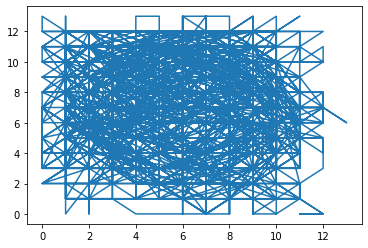

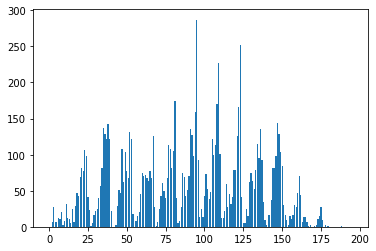

31.5


0.11224489795918367

In [35]:
np.random.seed(seed)
input = dataset(**dataset_config)
plt.figure();
plt.plot(input.xs, input.ys)
plt.show()

plt.figure();
states = np.argwhere(input.state_inputs)[:,0]
counts = np.zeros(input.num_states)
for state in np.arange(input.num_states):
    counts[state] = np.sum(states==state)
plt.bar(np.arange(input.num_states), counts)
plt.show()
print(np.median(counts))
np.sum(counts == 0)/input.num_states

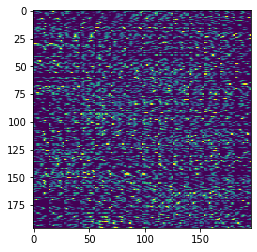

In [36]:
plt.figure()
plt.imshow(input.feature_maker.feature_map)
plt.show()

In [51]:
gamma=0.7

In [52]:
arena_length = int(np.sqrt(input.num_states)) - 1
walk_xs = input.xs.astype(int)
walk_ys = input.ys.astype(int)

In [53]:
input.dg_inputs.shape

(196, 9672)

In [54]:
T = np.zeros((num_states, num_states))
for i in range(1, input.dg_inputs.shape[1]):
    T += np.outer(input.dg_inputs[:,i-1], input.dg_inputs[:,i])
T = T/np.sum(T, axis=1)[:,None]
nan_idxs = np.argwhere(np.sum(np.isnan(T), axis=1))
if nan_idxs.size > 0:
    for nan_idx in nan_idxs:
        T[nan_idx,:] = np.zeros(num_states)
        T[nan_idx, (nan_idx-1)%num_states] = 1/3
        T[nan_idx, nan_idx] = 1/3
        T[nan_idx, (nan_idx+1)%num_states] = 1/3

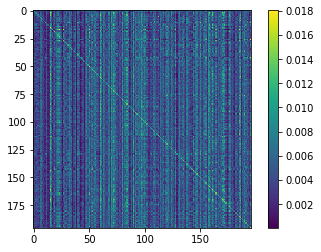

In [55]:
plt.figure()
plt.imshow(T)
plt.colorbar()
plt.show()

In [56]:
rnn = AnalyticSR(
    num_states=input_size, gamma=gamma,
    ca3_kwargs={
        'use_dynamic_lr':False, 'lr': 1E-3,
        #'parameterize': True,
        'alpha': 1.2, 'beta': 1.2
        }
    )
np.random.seed(seed)
outputs, loss, dset = run_rnn(
    '../trained_models/test/', rnn, dataset,
    dataset_config, gamma=gamma, test_over_all=False,
    train_net=False, return_dset=True
    )


[   51] loss: 0.033
Time per step 0.005s, net 0.256s

[  101] loss: 0.033
Time per step 0.006s, net 0.548s

[  151] loss: 0.032
Time per step 0.007s, net 0.898s

[  201] loss: 0.027
Time per step 0.007s, net 1.226s

[  251] loss: 0.025
Time per step 0.007s, net 1.565s

[  301] loss: 0.024
Time per step 0.007s, net 1.909s

[  351] loss: 0.024
Time per step 0.007s, net 2.245s

[  401] loss: 0.023
Time per step 0.008s, net 2.634s

[  451] loss: 0.023
Time per step 0.008s, net 3.026s

[  501] loss: 0.022
Time per step 0.007s, net 3.382s

[  551] loss: 0.022
Time per step 0.007s, net 3.744s

[  601] loss: 0.022
Time per step 0.007s, net 4.114s

[  651] loss: 0.022
Time per step 0.008s, net 4.501s

[  701] loss: 0.022
Time per step 0.007s, net 4.857s

[  751] loss: 0.022
Time per step 0.007s, net 5.194s

[  801] loss: 0.022
Time per step 0.007s, net 5.540s

[  851] loss: 0.022
Time per step 0.007s, net 5.884s

[  901] loss: 0.022
Time per step 0.007s, net 6.254s

[  951] loss: 0.022
Time pe


[ 7551] loss: 0.023
Time per step 0.008s, net 65.819s

[ 7601] loss: 0.022
Time per step 0.008s, net 66.227s

[ 7651] loss: 0.022
Time per step 0.008s, net 66.642s

[ 7701] loss: 0.021
Time per step 0.008s, net 67.060s

[ 7751] loss: 0.021
Time per step 0.008s, net 67.480s

[ 7801] loss: 0.020
Time per step 0.008s, net 67.896s

[ 7851] loss: 0.021
Time per step 0.008s, net 68.315s

[ 7901] loss: 0.021
Time per step 0.008s, net 68.736s

[ 7951] loss: 0.021
Time per step 0.008s, net 69.158s

[ 8001] loss: 0.021
Time per step 0.008s, net 69.580s

[ 8051] loss: 0.021
Time per step 0.008s, net 70.001s

[ 8101] loss: 0.021
Time per step 0.008s, net 70.425s

[ 8151] loss: 0.021
Time per step 0.010s, net 70.922s

[ 8201] loss: 0.021
Time per step 0.010s, net 71.409s

[ 8251] loss: 0.021
Time per step 0.009s, net 71.835s

[ 8301] loss: 0.021
Time per step 0.008s, net 72.259s

[ 8351] loss: 0.021
Time per step 0.008s, net 72.682s

[ 8401] loss: 0.022
Time per step 0.007s, net 73.047s

[ 8451] l

In [57]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = int(np.sqrt(dset.num_states))

# Option B: Load existing results

In [10]:
results_path = '../trained_models/03_td_discrete_corr/pval80_sigma1.5/0.6/rnn_fixedlr_alpha/2/results.p'
results_path = '../trained_models/03_td_discrete_corr/sparse_sigma1.5/0.6/hopfield/2/results.p'
with open(results_path, 'rb') as f:
    results = pickle.load(f)
outputs = results['outputs'].detach().numpy().squeeze()
dset = results['dset']

In [ ]:
walk_xs = dset.xs
walk_ys = dset.ys
arena_length = 10

# Make Plots

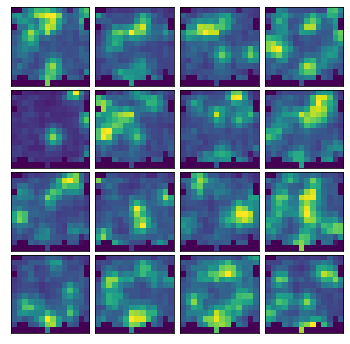

In [58]:
import matplotlib.gridspec as gridspec

grid_x = 4; grid_y = 4;

plt.figure(figsize = (6, 6))
gs1 = gridspec.GridSpec(grid_x, grid_y)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 

neurs = np.arange(outputs.shape[1])
np.random.shuffle(neurs)

idx = 0
for neur in neurs:
    firing_field = np.zeros((arena_length, arena_length))*np.nan
    for x in range(arena_length):
        for y in range(arena_length):
            frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
            fr = np.nanmean(outputs[frame_idxs, neur])
            firing_field[x,y] = fr
    firing_field[np.isnan(firing_field)] = 0    
    if not np.any(firing_field > 0): continue
    ax = plt.subplot(gs1[idx])
    plt.axis('on')
    ax.imshow(firing_field/firing_field.max(), vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    idx += 1
    if idx == grid_x*grid_y: break
plt.show()

# Metrics

In [59]:
from findpeaks import findpeaks
from scipy.ndimage.measurements import label

In [60]:
# Area and Peaks

def get_area_and_peaks(firing_field):
    area_thresh = ceil(0.00716197244*firing_field.size)
    masked_field = firing_field > 0.8
    labeled_array, ncomponents = label(masked_field, np.ones((3,3)))
    areas = []
    for label_id in np.unique(labeled_array):
        if label_id == 0: continue
        area = np.sum(labeled_array == label_id)
        if area < area_thresh: continue
        areas.append(area)
    return areas, len(areas)

# Spatial Info

def flatten_xy(walk_xs, walk_ys):
    max_col = walk_ys.max()
    new_bins = walk_xs * max_col + walk_ys
    return new_bins

def circular(fr):
    """
    Circularly shuffles a (neur, frames) array of firing rates, neuron by neuron.
    """

    fr = fr.copy()
    shift = np.random.choice(np.arange(1, fr.size))
    if len(fr.shape) == 2:
        num_neur, num_frames = fr.shape
        for neur in range(num_neur):
            shift = np.random.choice(np.arange(1, num_frames))
            fr[neur,:] = np.roll(fr[neur,:], shift)
        return fr
    else:
        return np.roll(fr, shift)
    
def get_mutual_info(conditions, fr):
    """
    Calculates mutual information between firing rate and a set of conditions

    Args:
        conditions: (frames,) array of conditions
        fr: (neurs, frames) array of firing rates
    Returns:
        (neurs,) array of scaler value mutual information per neuron
    """

    num_neurs, _ = fr.shape
    mean_fr = np.mean(fr, axis=1)
    mutual_info = np.zeros(num_neurs)
    for condn in np.unique(conditions):
        prob = np.sum(conditions==condn)/conditions.size
        condn_mean_fr = np.mean(fr[:,conditions==condn], axis=1)
        log_term = np.log2(condn_mean_fr/mean_fr)
        log_term[np.isnan(log_term)] = 0
        log_term[np.isinf(log_term)] = 0
        mutual_info += prob*condn_mean_fr*log_term
    return mutual_info

def calc_place_cells(xs, ys, fr, num_shuffles):
    """ Gets the spatial mutual information of each cell."""

    num_neurs, num_frames = fr.shape
    spatial_info = np.zeros(num_neurs)
    significance = np.zeros(num_neurs)
    conditions = flatten_xy(xs, ys)
    spatial_info = get_mutual_info(conditions, fr)
    
    for _ in range(num_shuffles):
        shuffled_fr = circular(fr)
        shuffled_info = get_mutual_info(conditions, shuffled_fr)
        significance += (shuffled_info < spatial_info)
    significance /= num_shuffles
    
    return spatial_info, significance

def get_metrics(outputs, dset):
    walk_xs = dset.xs.astype(int)
    walk_ys = dset.ys.astype(int)
    arena_length = 10
    
    areas = []
    ncomps = []

    spatial_info, significance = calc_place_cells(
        walk_xs, walk_ys, outputs.T, 100
        )

    for neur in np.arange(outputs.shape[1]):
        firing_field = np.zeros((arena_length, arena_length))*np.nan
        for x in range(arena_length):
            for y in range(arena_length):
                frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
                fr = np.nanmean(outputs[frame_idxs, neur])
                firing_field[x,y] = fr
        firing_field[np.isnan(firing_field)] = 0

        # Area?
        area, ncomp = get_area_and_peaks(firing_field)
        areas.append(np.sum(area))
        ncomps.append(ncomp)
    return np.array(areas), np.array(ncomps), spatial_info

In [61]:
areas, ncomps, spatial_info = get_metrics(outputs, input)

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log2


In [62]:
np.mean(ncomps)

1.8265306122448979

In [63]:
np.mean(areas)/(arena_length**2)

0.09834443981674303

In [64]:
sum(ncomps==1)/ncomps.size

0.2857142857142857

In [65]:
rnn.ca3.beta

1.2